# Plan
- [x] load data ~ 30 min
- [x] Make prediction ~ 30 min
- [x] Train model ~ 10 min
    - [x] Fix model ~ 40 min
- [x] Submit work ~ 5 min

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T 
from torch.utils.data import Dataset, DataLoader

from PIL import Image 

from efficientnet_pytorch import EfficientNet

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [2]:
'''
Global variables
'''
FOLDS = 5
EPOCHS = 10
batch_size = 512

img_size = 44 # square

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


## Data preparation 
Preparing files paths,  
Remap and translate to numbers our target values

In [3]:
data_path = '../data'
path_20 = data_path + '/2020/128x128'
path_19 = data_path + '/2019/128x128'

In [4]:
df_19 = pd.read_csv(path_19 + '/train.csv')
df_20 = pd.read_csv(path_20 + '/train.csv')

df_20_test = pd.read_csv(path_20 + '/test.csv')

In [5]:
# df_19 = df_19[['image_name', 'diagnosis']]
# df_20 = df_20[['image_name', 'diagnosis']]

df_19 = df_19[['image_name', 'target']]
df_20 = df_20[['image_name', 'target']]
df_20_test = df_20_test[['image_name']]

### Preparing files paths 

In [6]:
df_19['image_name'] = [path_19+'/train/'+name+'.jpg' for name in df_19['image_name']]
df_20['image_name'] = [path_20+'/train/'+name+'.jpg' for name in df_20['image_name']]

df_20_test['image_name'] = [path_20+'/test/'+name+'.jpg' for name in df_20_test['image_name']]

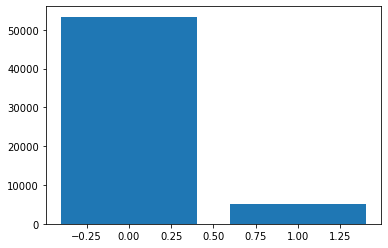

In [7]:
mega_df = df_19.append(df_20)
total_targets = np.unique(np.append(df_19['target'].unique(), df_20['target'].unique()))
stats = {l:(mega_df['target'] == l).sum() for l in mega_df['target'].unique()}

plt.bar(total_targets, [v for _,v in stats.items()])
plt.show()

### Make Dataset

In [8]:
class ISIC_DS(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None, isTest=False):
        self.df = df
        self.transform = transform
        self.isTest = isTest
        
    def __getitem__(self, idx):
        if self.isTest: return self._get_test_item(idx)
            
        path, target = self.df.iloc[idx]
        
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return self.df.shape[0]
    
    def _get_test_item(self, idx):
        path = self.df.iloc[idx][0]
        
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img

### Transformations

In [9]:
transform = {'train': T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
            
             'val':T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}


### Make a DataLoader

In [10]:
def get_loaders(df, train_idx, val_idx, bs=batch_size, t=transform, test_df=df_20_test):
    loaders = {'train':None, 'val':None, 'test':None}
    
    loaders['train'] = DataLoader(ISIC_DS(df.iloc[train_idx], t['train']), bs, num_workers=12)
    loaders['val']   = DataLoader(ISIC_DS(df.iloc[val_idx], t['val']), bs, num_workers=12)
    loaders['test']  = DataLoader(ISIC_DS(test_df, t['val'], isTest=True), bs, num_workers=12)
    
    return loaders

## Get a model

In [11]:
def get_model(name, num_classes=2, device=device, sigmoid=True):
    if name == 'b0':
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
    elif name == 'b1':
        model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=num_classes)
       
    if sigmoid:
        # Model reshaping
        in_features = model._fc.in_features
        out_features = model._fc.out_features

        model._fc = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Sigmoid())
        
    return model.to(device)

## Get test predictions

In [12]:
def preds_to_list(predictions):
    # make probabilities from predictions
    final = []
    for pred in predictions:
        prob, index = torch.max(pred, 1)
        prob[index == 0] = 1 - prob[index == 0]
        final += prob.tolist()
    return final
    
def get_test_predictions(loader, prefix=''):
    model.eval()
    predictions = []

    for batch_x in loader:
        batch_x = batch_x.to(device)
        output = model(batch_x)

        predictions.append(output.detach().cpu())
        
    final = preds_to_list(predictions)
        
    final_submission = pd.read_csv(path_20 + '/sample_submission.csv')
    final_submission['target'] = final
    final_submission.to_csv(f'outputs/oof_test_{prefix}.csv', index=False)
    

## Train the model functions

In [13]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        # set model to train mode
        model.train()
        # make predictions
        yhat = model(x)
        # computes loss
        loss = loss_fn(yhat, y)
        # computes gradients
        loss.backward()
        # updats parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return yhat, loss.item()
    return train_step

In [14]:
def make_val_step(model, loss_fn):
    def val_step(x, y):
        with torch.no_grad():
            model.eval()

            yhat = model(x)
            val_loss = loss_fn(yhat, y)

            return val_loss.item()
    return val_step

In [15]:
# Training loop
def train_loop(train_step, val_step, loaders, epochs=EPOCHS):
    for epoch in range(epochs):
        running_loss = []
        running_vloss= []
        
        running_yhat = []
        running_y = []
        
        for batch_x, batch_y in loaders['train']:
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 

            yhat, loss = train_step(batch_x, batch_y)
            running_loss.append(loss)
            running_yhat.append(yhat.detach().cpu())
            running_y += batch_y.detach().cpu().tolist()

        for batch_x, batch_y in loaders['val']:
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 
            
            vloss = val_step(batch_x, batch_y)
            running_vloss.append(vloss)
            
        # Compute auc score
        running_yhat = preds_to_list(running_yhat) 
        auc_score = roc_auc_score(running_y, running_yhat) 
  
        print('[{}/{}] loss: {:.3f} auc: {:.3f}'
              .format(epoch+1, epochs, np.mean(running_loss), auc_score))
    return np.mean(running_loss), auc_score

In [16]:
def save_loss_auc(loss, auc, fold, m_name=''):
    file_name = 'outputs/models_oof_info.csv'
    
    head=['model_name', 'fold', 'loss', 'auc']

    df = pd.DataFrame(columns=head)

    new_row = dict(zip(head, [m_name, fold, loss, auc]))

    df = df.append(new_row, ignore_index=True)

    if os.path.exists(file_name):
        df.to_csv(file_name, mode='a', header=False, index=False)
    else:
        df.to_csv(file_name, index=False)
        
def save_val_preds(loader, prefix=''):
    file_name = f'outputs/oof_val_{prefix}.csv'
    
    oof_preds = []
    oof_y = []
    
    for batch_x, y in loader:
        batch_x = batch_x.to(device)  

        with torch.no_grad():
            model.eval()
            yhat = model(batch_x)
            
            oof_preds.append(yhat.detach().cpu())
            oof_y += y.tolist()
            
    oof_preds = preds_to_list(oof_preds)
    
    df = pd.DataFrame()
    df['y_true'] = oof_y
    df['y_pred'] = oof_preds
    df.to_csv(file_name, index=False)
    

In [26]:
##### K-fold cross validation
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=95)
total_idx = np.arange(mega_df.shape[0])

model_name = 'b1'

for fold, (train_idx, val_idx) in enumerate(skf.split(total_idx)):
    print(f'FOLD: {fold}')
    # Set data
    loaders = get_loaders(mega_df, train_idx, val_idx)
    
    # Set model
    model = get_model(model_name, device=device)

    # Preapering to training
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

    train_step = make_train_step(model, loss_fn, optimizer)

    # Set train/val step
    train_step = make_train_step(model, loss_fn, optimizer)
    val_step = make_val_step(model, loss_fn)
    
    # Train loop
    loss, auc = train_loop(train_step, val_step, loaders, epochs=3)
    
    # Prediction loop
    get_test_predictions(loaders['test'], prefix=model_name+'_'+str(fold))
    save_val_preds(loaders['val'], prefix=model_name+'_'+str(fold))
#     save_loss_auc(loss, auc, fold, model_name)

FOLD: 0
Loaded pretrained weights for efficientnet-b1
[1/3] loss: 0.705 auc: 0.499
[2/3] loss: 0.686 auc: 0.498
[3/3] loss: 0.669 auc: 0.499
FOLD: 1
Loaded pretrained weights for efficientnet-b1
[1/3] loss: 0.683 auc: 0.548
[2/3] loss: 0.666 auc: 0.539
[3/3] loss: 0.652 auc: 0.527
FOLD: 2
Loaded pretrained weights for efficientnet-b1
[1/3] loss: 0.700 auc: 0.519
[2/3] loss: 0.681 auc: 0.530
[3/3] loss: 0.664 auc: 0.522
FOLD: 3
Loaded pretrained weights for efficientnet-b1
[1/3] loss: 0.696 auc: 0.507
[2/3] loss: 0.678 auc: 0.519
[3/3] loss: 0.662 auc: 0.519
FOLD: 4
Loaded pretrained weights for efficientnet-b1
[1/3] loss: 0.670 auc: 0.499
[2/3] loss: 0.654 auc: 0.506
[3/3] loss: 0.641 auc: 0.499


## Model Ensembling

In [73]:
all_scores = []

# get total oof predictions
oof = {'b0':pd.DataFrame(), 'b1':pd.DataFrame()}

for i in range(5):
    oof['b0'] = pd.concat([oof['b0'], pd.read_csv(f'outputs/oof_val_b0_{i}.csv')], ignore_index=True)
    oof['b1'] = pd.concat([oof['b1'], pd.read_csv(f'outputs/oof_val_b1_{i}.csv')], ignore_index=True)

for w in np.arange(0,1,0.01):
    y_pred = w * oof['b0']['y_pred'].values + (1-w)*oof['b1']['y_pred'].values

    auc = roc_auc_score(oof['b0']['y_true'], y_pred)

    all_scores.append(auc)

In [82]:
max_idx = np.argmax(all_scores)
max_w = np.arange(0, 1, 0.01)[max_idx]

print('Weight: {}, AUC: {:.3f}'
      .format(max_w, all_scores[max_idx]))

Weight: 0.99, AUC: 0.483


In [92]:
oof_test = {'b0':[], 'b1':[]}

for i in range(5):
    oof_test['b0'] += [pd.read_csv(f'outputs/oof_test_b0_{i}.csv')['target'].values] 
    oof_test['b1'] += [pd.read_csv(f'outputs/oof_test_b1_{i}.csv')['target'].values] 

oof_test['b0'] = np.mean(oof_test['b0'], 0)
oof_test['b1'] = np.mean(oof_test['b1'], 0)


y_pred = max_w * oof_test['b0'] + (1-max_w)*oof_test['b1']['target'].values


(10982,)

## Final submission

In [ ]:
def plot_predictions(preds):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(6,3), dpi=120)
    sns.distplot(preds, hist_kws={
                     'rwidth': 0.75,
                     'edgecolor': 'black',
                     'alpha': 0.3
                 }, color='#1B9CC2')
    ax.set_title('Final Predictions')
    plt.show()

In [ ]:
plot_predictions(final)

In [ ]:
final_submission = pd.read_csv(path_20 + '/sample_submission.csv')
final_submission['target'] = final
final_submission.to_csv('final_submission.csv', index=False)